# 작전
* NA 처리
* SalePrice만 log 처리
* NA 처리 이후에, df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] 피쳐 생성
* 카테고리 변수 처리

# 작전상 제외
* log 변환
* poly 피쳐 엔지니어링

# Load modules

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
print(os.listdir("../data/raw/house"))

['test.csv', 'data_description.txt', 'train.csv', 'sample_submission.csv']


# Load data

In [2]:
df_train = pd.read_csv("../data/raw/house/train.csv")
df_test = pd.read_csv("../data/raw/house/test.csv")
df_train['MlUse'] = 'train'
df_test['MlUse'] = 'test'
df = pd.concat([df_train, df_test], axis=0)

In [3]:
# Id, MlUse 필드 빼면 80개 필드
df.sample(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
5    1466          60       RL         75.0    10000   Pave   NaN      IR1   
907   908          50       RL         86.0    11500   Pave   NaN      IR1   
446  1907          20       RL        100.0    17500   Pave   NaN      Reg   

    LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
5           Lvl    AllPub  ...    NaN   NaN         NaN       0      4   2010   
907         Lvl    AllPub  ...    NaN   NaN         NaN       0      6   2006   
446         Bnk    AllPub  ...    NaN   NaN         NaN       0      1   2009   

    SaleType  SaleCondition  SalePrice  MlUse  
5         WD         Normal        NaN   test  
907       WD         Normal   250000.0  train  
446       WD         Normal        NaN   test  

[3 rows x 82 columns]

In [4]:
# train: (1460, 81), test: (1459, 80)
print("Shape train: {tr_shape}, test: {te_shape}".format(
                    tr_shape=df[df['MlUse']=='train'].shape, te_shape=df[df['MlUse']=='test'].shape))

Shape train: (1460, 82), test: (1459, 82)


In [5]:
df.describe() # numeric은 80개 필드 중, 38개

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2433.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    23.344905    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    59.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    68.000000    9453.000000     6.000000   
75%    2189.500000    70.000000    80.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000  ...   
mean      5.564577  1971.312778   1984.264474   102.201312   441.423235  ...   
std       1.113131    30.291442     20.894344   179.334253   455.610826  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.500000   1965.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1993.000000     0.000000   368.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   733.000000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  2919.000000  2919.000000    2919.000000  2919.000000  2919.000000   
mean     93.709832    47.486811      23.098321     2.602261    16.062350   
std     126.526589    67.575493      64.244246    25.188169    56.184365   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    26.000000       0.000000     0.000000     0.000000   
75%     168.000000    70.000000       0.000000     0.000000     0.000000   
max    1424.000000   742.000000    1012.000000   508.000000   576.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  2919.000000   2919.000000  2919.000000  2919.000000    1460.000000  
mean      2.251799     50.825968     6.213087  2007.792737  180921.195890  
std      35.663946    567.402211     2.714762     1.314964   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     4.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     800.000000  17000.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

# 피쳐 엔지니어링

## y값 체크

In [6]:
import warnings
warnings.filterwarnings('ignore')

width=6.0, height=4.0


Text(0.5, 1.0, 'log transform SalePrice histogram')

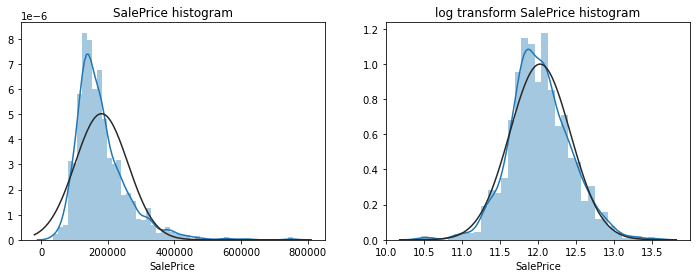

In [7]:
from scipy import stats                                                         

fig, ax = plt.subplots(1,2) # row 1개, column 2개
width, height = fig.get_size_inches()
print('width={w}, height={h}'.format(w=width,h=height))
fig.set_size_inches(width*2, height)
sns.distplot(df[df['MlUse']=='train']['SalePrice'], ax=ax[0], fit=norm).set_title('SalePrice histogram')
sns.distplot(np.log1p(df[df['MlUse']=='train']["SalePrice"]), ax=ax[1], fit=norm).set_title('log transform SalePrice histogram')
# log 변환하면, norm dist에 가까워짐!

### 가장 중요한 SalePrice를 log 변환

In [8]:
df.loc[df['MlUse']=='train',"SalePrice"] = np.log1p(df[df['MlUse']=='train']["SalePrice"])

Text(0.5, 1.0, 'log-transformed SalePrice histogram')

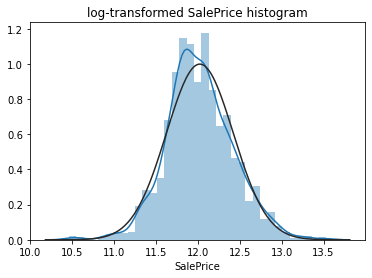

In [9]:
sns.distplot(df[df['MlUse']=='train']["SalePrice"], fit=norm).set_title('log-transformed SalePrice histogram')

## Constant (여러 값들로 채워져 있지 않은 필드) 필드 drop 하기

In [10]:
# Utilities는 AllPub이라는 값 외에는 없었으니 없애자
drop_feats = ['Street', 'Utilities', 'PoolQC']
df.drop(drop_feats, axis=1, inplace=True)

## missing data 처리 필드 찾기

In [11]:
df_na = 100 * df.isnull().sum() / len(df)
display(df_na[1:4])

MSSubClass      0.000000
MSZoning        0.137033
LotFrontage    16.649538
dtype: float64

In [12]:
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na.drop('SalePrice', inplace=True) # SalePrice 은 예외!
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(3) # missing이 80% 이상 데이터는 사용 불가능할듯. LotFrontage 데이터부터는 살려 볼 수 있을까?

Missing Ratio
MiscFeature      96.402878
Alley            93.216855
Fence            80.438506

In [13]:
# 필드 중에 대부분은 str이고, LotFrontage, GarageYrBlt 정도만 숫자 필드군..
right = pd.DataFrame(df.dtypes)
left = missing_data
left.join(right,how='left')

Missing Ratio        0
MiscFeature       96.402878   object
Alley             93.216855   object
Fence             80.438506   object
FireplaceQu       48.646797   object
LotFrontage       16.649538  float64
GarageCond         5.447071   object
GarageYrBlt        5.447071  float64
GarageFinish       5.447071   object
GarageQual         5.447071   object
GarageType         5.378554   object
BsmtCond           2.809181   object
BsmtExposure       2.809181   object
BsmtQual           2.774923   object
BsmtFinType2       2.740665   object
BsmtFinType1       2.706406   object
MasVnrType         0.822199   object
MasVnrArea         0.787941  float64
MSZoning           0.137033   object
Functional         0.068517   object
BsmtHalfBath       0.068517  float64
BsmtFullBath       0.068517  float64
KitchenQual        0.034258   object
TotalBsmtSF        0.034258  float64
BsmtUnfSF          0.034258  float64
GarageCars         0.034258  float64
GarageArea         0.034258  float64
BsmtFinSF2         0.034258  float64
BsmtFinSF1         0.034258  float64
Exterior2nd        0.034258   object

## NA 변환 함수

In [14]:
def fill_missing(df, cols, val):
    """ Fill with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

## NA를 처리하자

In [15]:
# NA를 None 값으로 처리 (의미적 처리)
fill_missing(df, ["MiscFeature", "Alley", "Fence", "FireplaceQu", 
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       "MasVnrType", "MSSubClass"], "None")
# NA를 Unknown으로.
fill_missing(df, ['Electrical'], 'Unknown')
# NA를 0 으로 처리 (의미적 처리)
fill_missing(df, ["GarageYrBlt", "GarageArea", "GarageCars",
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                       "MasVnrArea"], 0)
fill_missing_with_mode(df, ["MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"])
fill_missing(df, ["Functional"],"Typ")

## GarageYrBlt
* 년도가 아닌 0의 값이 있는 row들이 많다
* 0을 YearBuilt와 같은 값으로 채운다
* df.loc[<mask>(here mask is generating the labels to index) , <optional column(s)> ]
* df.loc[df['First Season'] > 1990, 'First Season'] = 1
* e.g. df['First Season'] = np.where(df['First Season'] > 1990, 1, df['First Season'])

In [42]:
df.loc[df['GarageYrBlt']==0,'GarageYrBlt'] = df['YearBuilt']

In [45]:
df[['GarageYrBlt','YearBuilt']].head(5)

GarageYrBlt  YearBuilt
0       2003.0       2003
1       1976.0       1976
2       2001.0       2001
3       1998.0       1915
4       2000.0       2000

In [16]:
df[["Functional","MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"]].head(3)

Functional MSZoning KitchenQual Exterior1st Exterior2nd SaleType
0        Typ       RL          Gd     VinylSd     VinylSd       WD
1        Typ       RL          TA     MetalSd     MetalSd       WD
2        Typ       RL          Gd     VinylSd     VinylSd       WD

In [17]:
df_na = 100 * df.isnull().sum() / len(df)

In [18]:
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na.drop('SalePrice', inplace=True)
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data # LotFrontage 데이터 이후부터는 사용 불가일 듯...

Missing Ratio
LotFrontage      16.649538

### LotFrontage의 missing ratio가 17%이긴 하지만, 좀 살려보자 (why? SalePrice와는 corr가 괜찮음)

In [19]:
# LotFrontage는 대략 21%가 NA였는데, 가장 비슷한 값을 넣어주려고, 이웃들의 LotFrontage의 가장 많은 값(median)을 넣어주자
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
                                            lambda x: x.fillna(x.median()))

### OverallQual 가 높아야 SalePrice 가 높아지는데, 
* OverallQual가 낮아도 SalePrice가 높은 row들은 제거하자
* GrLivArea가 높은데도, SalePrice가 낮은 row들도 제거하자

In [20]:
df.drop(df[(df['OverallQual']<5) & (df['SalePrice']>200000) & (df['MlUse']=='train')].index, inplace=True)
df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000) & (df['MlUse']=='train')].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [21]:
# 2919 --> 2911 (4개 row가 삭제)
df.shape

(2911, 79)

### 숫자 필드 중에, 카테고리성 필드가 있어서,
* 이들 필드는 카테고리로 형태 변환하자

In [22]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

### NA 다시 체크
* NA 더이상 없음을 확인

In [23]:
df_na = 100 * df.isnull().sum() / len(df)
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na.drop('SalePrice', inplace=True)
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data # LotFrontage 데이터 이후부터는 사용 불가일 듯...

Empty DataFrame
Columns: [Missing Ratio]
Index: []

## 카테고리성 변수들의 처리

In [24]:
# 카테고리변수 필드 처리 --> 숫자 카테고리로 변환
# pd.factorize 를 사용하자... 
# https://www.geeksforgeeks.org/python-pandas-factorize/
from pandas.api.types import is_string_dtype


categorical_feats = [
        f for f in df.columns if (is_string_dtype(df[f]) and f!='MlUse')
]

print(categorical_feats)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


### pd.factorize를 이용한 encode

In [25]:
indexers = {} # map
for f_ in categorical_feats:
    df[f_], indexer = pd.factorize(df[f_])
    indexers[f_] = indexer

In [26]:
indexers

{'MSSubClass': Index(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
        '160', '75', '180', '40', '150'],
       dtype='object'),
 'MSZoning': Index(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype='object'),
 'Alley': Index(['None', 'Grvl', 'Pave'], dtype='object'),
 'LotShape': Index(['Reg', 'IR1', 'IR2', 'IR3'], dtype='object'),
 'LandContour': Index(['Lvl', 'Bnk', 'Low', 'HLS'], dtype='object'),
 'LotConfig': Index(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype='object'),
 'LandSlope': Index(['Gtl', 'Mod', 'Sev'], dtype='object'),
 'Neighborhood': Index(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
        'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW',
        'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr',
        'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste'],
       dtype='object'),
 'Condition1': Index(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
     

In [27]:
df[categorical_feats].tail(5)

MSSubClass  MSZoning  Alley  LotShape  LandContour  LotConfig  \
2906          11         1      0         0            0          0   
2907          11         1      0         0            0          0   
2908           1         0      0         0            0          0   
2909           9         0      0         0            0          0   
2910           0         0      0         0            0          0   

      LandSlope  Neighborhood  Condition1  Condition2  ...  GarageFinish  \
2906          0            14           0           0  ...             3   
2907          0            14           0           0  ...             1   
2908          0             4           0           0  ...             1   
2909          0             4           0           0  ...             3   
2910          1             4           0           0  ...             2   

      GarageQual  GarageCond  PavedDrive  Fence  MiscFeature  MoSold  YrSold  \
2906           3           2           0      0            0      11       2   
2907           0           0           0      0            0       7       2   
2908           0           0           0      0            0       2       2   
2909           3           2           0      1            1       9       2   
2910           0           0           0      0            0       6       2   

      SaleType  SaleCondition  
2906         0              0  
2907         0              1  
2908         0              1  
2909         0              0  
2910         0              0  

[5 rows x 43 columns]

## 신규 필드 생성

In [28]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Feature Engineering 이후의 데이터 프로파일링 해보기

## 카테고리성 필드 profiling

In [47]:
categorical_feats.append('SalePrice')
print(categorical_feats)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']


In [32]:
from pandas_profiling import ProfileReport

In [48]:
# 1분 30초 걸림 (숫자 데이터가 되니 조금 더 걸리는군..)
profile = ProfileReport(df[df['MlUse']=='train'][categorical_feats].sample(frac=0.2), 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_shallow_FE_categorical_transformed_data.html")

## Numeric 필드 profiling

In [34]:
numeric_feats = list(df.columns.values)
numeric_feats.remove("Id")
for f_ in categorical_feats:
    numeric_feats.remove(f_)
    
numeric_feats.append('SalePrice')
print(numeric_feats)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'MlUse', 'TotalSF']


In [46]:
# 2분 걸림 
profile = ProfileReport(df[df['MlUse']=='train'][numeric_feats].sample(frac=0.2), 
                        explorative=False,
                        correlations=None,
                        progress_bar=False,
)


#Saving results to a HTML file
profile.to_file("data_profile/profile_shallow_FE_numeric_transformed_data.html")

# Save DF

In [37]:
import joblib

In [49]:
filename = '../data/processed/house/df_shallow_FE_transformed.pickle'
joblib.dump(df, filename)

['../data/processed/house/df_shallow_FE_transformed.pickle']